In [1]:
import mediapipe as mp
import cv2 as cv
import os
import matplotlib.pyplot as plt
import time
import numpy as np


In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv.cvtColor(image,cv.COLOR_RGB2BGR)
    return image,results

In [4]:
def draw_landmarks(image,result):
    mp_drawing.draw_landmarks(image,result.face_landmarks, mp_holistic.FACEMESH_TESSELATION,mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(224, 224, 224), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image,result.pose_landmarks,mp_holistic.POSE_CONNECTIONS,mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(224, 224, 224), thickness=2, circle_radius=1))
    mp_drawing.draw_landmarks(image,result.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image,result.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)

In [6]:
cap = cv.VideoCapture(0)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5)
while cap.isOpened():
    ret,frame = cap.read()
    images,result = mediapipe_detection(frame,holistic)
    draw_landmarks(images,result)
    cv.imshow("frame",images)
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

In [7]:
draw_landmarks(frame,result)

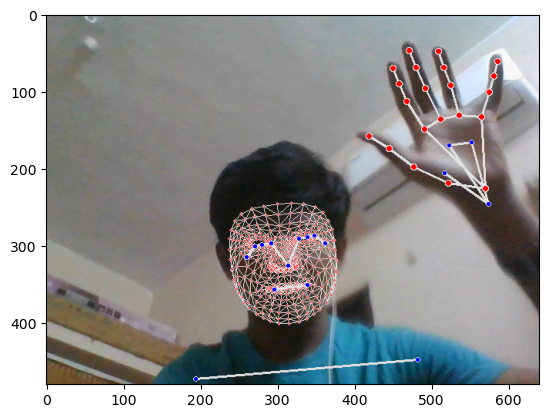

In [8]:
plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB))

In [9]:
len(result.pose_landmarks.landmark)

33

In [10]:
pose = np.array([[res.x,res.y,res.z,res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(132)

In [11]:
len(result.face_landmarks.landmark)*3

1404

In [12]:
result.left_hand_landmarks.landmark

[x: 0.8911727666854858
y: 0.4708535075187683
z: 5.214987481849676e-07
, x: 0.8168393969535828
y: 0.4569307267665863
z: -0.025432156398892403
, x: 0.7466999292373657
y: 0.4136122763156891
z: -0.03334597125649452
, x: 0.6959875822067261
y: 0.3629343509674072
z: -0.03972841426730156
, x: 0.6549487709999084
y: 0.33011481165885925
z: -0.04397468641400337
, x: 0.7674810886383057
y: 0.31203898787498474
z: -0.0048368279822170734
, x: 0.73231041431427
y: 0.23651781678199768
z: -0.017681986093521118
, x: 0.7162429094314575
y: 0.18883921205997467
z: -0.029249075800180435
, x: 0.7041752338409424
y: 0.14715687930583954
z: -0.038066186010837555
, x: 0.8010090589523315
y: 0.28420183062553406
z: -0.004683628678321838
, x: 0.7697606682777405
y: 0.2000965029001236
z: -0.014915388077497482
, x: 0.7505996823310852
y: 0.14565804600715637
z: -0.026825519278645515
, x: 0.7364866137504578
y: 0.0990356057882309
z: -0.035802874714136124
, x: 0.8389975428581238
y: 0.27352994680404663
z: -0.009560652077198029
, x

In [5]:
def extract_keypoints(result):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*3)
    face = np.array([[res.x,res.y,res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3)
    right_hand = np.array([[res.x,res.y,res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
    left_hand = np.array([[res.x,res.y,res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,left_hand,right_hand])

In [21]:
k = extract_keypoints(result)

In [22]:
len(k)

1662

In [6]:
path = os.path.join("Data")
actions = np.array(["Hello","Thanks","ILoveYou"])
no_of_sequences = 30
sequence_length = 30
for act in actions:
    for seq in range(no_of_sequences):
        try :
            os.makedirs(os.path.join(path,act,str(seq)))
        except:
            pass

In [16]:
cap = cv.VideoCapture(0)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5)
for act in actions:
    for seq in range(no_of_sequences):
        for frames in range(sequence_length):
            ret , frame = cap.read()
            image , result = mediapipe_detection(frame,holistic)
            draw_landmarks(image,result)

            if frames == 0:
                cv.putText(image,"Collecting...",(120,200),cv.FONT_HERSHEY_DUPLEX,1,(255,0,0),1,cv.LINE_4)
                cv.putText(image,"Collecting frame for {} seq {}".format(act,seq),(120,200),cv.FONT_HERSHEY_DUPLEX,1,(255,0,0),1,cv.LINE_4)
                cv.waitKey(3000)
            else:
                cv.putText(image,"Collecting frame for {} seq {}".format(act,seq),(120,200),cv.FONT_HERSHEY_DUPLEX,1,(255,0,0),1,cv.LINE_4)
            landmarks = extract_keypoints(result)
            arrays = os.path.join(path,act,str(seq),str(frames))
            np.save(arrays,landmarks)

            cv.imshow("Frame",image)

            if cv.waitKey(10) & 0xFF == ord('q'):
                    break
cap.release()
cv.destroyAllWindows()

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [15]:
labels = {label:code for code,label in enumerate(actions)}

In [19]:
videos = []
label = []
for act in actions:
    for seq in range(no_of_sequences):
        sequence = []
        for frame in range(sequence_length):
            array = np.load(os.path.join(path,act,str(seq),"{}.npy".format(frame)))
            sequence.append(array)
        videos.append(sequence)
        label.append(labels[act])

In [21]:
X = np.array(videos)
y = to_categorical(label).astype(int)

In [24]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.05)

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64,return_sequences=True,activation = 'relu', input_shape = (30,1662)))
model.add(tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.LSTM(64, return_sequences=False,activation = 'relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(3,activation='softmax'))  

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [8]:
model.compile(optimizer="adam", loss = "categorical_crossentropy",metrics = ['categorical_accuracy'])

In [42]:
history = model.fit(x_train,y_train,epochs=2000)

Epoch 1/2000
3/3 [==============================] - 9s 109ms/step - loss: 3.6303 - categorical_accuracy: 0.3176
Epoch 2/2000
3/3 [==============================] - 0s 111ms/step - loss: 19.6114 - categorical_accuracy: 0.3412
Epoch 3/2000
3/3 [==============================] - 0s 160ms/step - loss: 20.4018 - categorical_accuracy: 0.3412
Epoch 4/2000
3/3 [==============================] - 0s 126ms/step - loss: 20.1189 - categorical_accuracy: 0.2000
Epoch 5/2000
3/3 [==============================] - 0s 123ms/step - loss: 15.6658 - categorical_accuracy: 0.3412
Epoch 6/2000
3/3 [==============================] - 0s 112ms/step - loss: 60.7936 - categorical_accuracy: 0.3529
Epoch 7/2000
3/3 [==============================] - 0s 106ms/step - loss: 64.3787 - categorical_accuracy: 0.3765
Epoch 8/2000
3/3 [==============================] - 0s 113ms/step - loss: 59.5419 - categorical_accuracy: 0.3529
Epoch 9/2000
3/3 [==============================] - 0s 125ms/step - loss: 28.3695 - categorical_a

In [44]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy'])

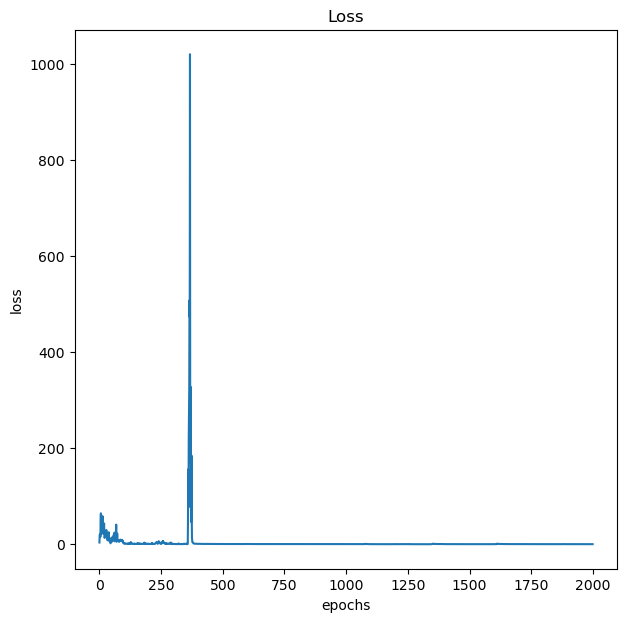

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

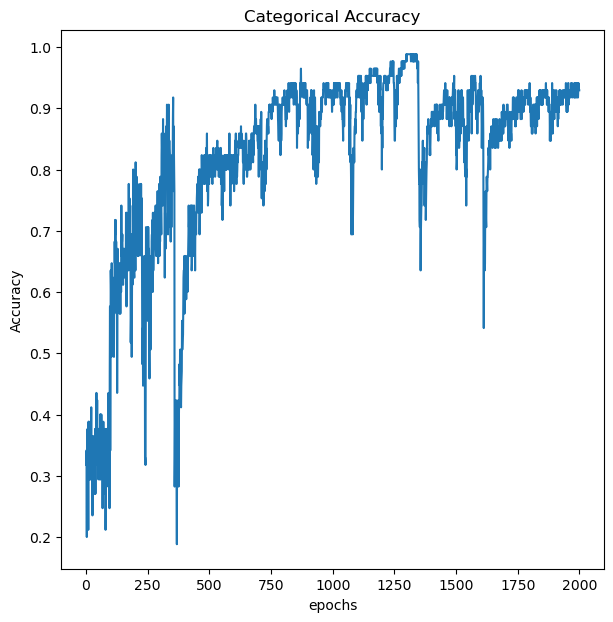

In [46]:
plt.figure(figsize=(7,7))
plt.plot(history.history['categorical_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')
plt.show()

In [47]:
result = model.predict(x_test)

1/1 [==============================] - 3s 3s/step


In [50]:
actions[np.argmax(result[1])]

'ILoveYou'

In [51]:
actions[np.argmax(y_test[1])]

'ILoveYou'

In [52]:
model.save("mediapipe_model.h5")

In [8]:
model = tf.keras.models.load_model("mediapipe_model.h5")

In [9]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [54]:
y_true = np.argmax(y_test,axis=1).tolist()
y_pred = np.argmax(result,axis = 1).tolist()

In [55]:
multilabel_confusion_matrix(y_true,y_pred)

array([[[2, 0],
        [2, 1]],

       [[1, 2],
        [0, 2]]], dtype=int64)

In [56]:
accuracy_score(y_true,y_pred)

0.6

In [10]:
colors = [(116,223,34),(117,245,16),(24,244,196)]
def probability(pred,actions,frame,colors):
    my_frame = frame.copy()
    for i,j in enumerate(pred):
        cv.rectangle(my_frame, (0,60+i*40),(int(j*100), 90+i*40),colors[i],-1)
        cv.putText(my_frame,actions[i],(0,85+i*40),cv.FONT_HERSHEY_COMPLEX, 1,(255,255,255),1,cv.LINE_8)
    return my_frame

In [13]:
sequence = []
sentence = []
threshold = 0.9
cap = cv.VideoCapture(0)
holistic = mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5)
while cap.isOpened():
    ret,frame = cap.read()
    images,result = mediapipe_detection(frame,holistic)
    draw_landmarks(images,result)
    keypoints = extract_keypoints(result)
    sequence.insert(0,keypoints)
    sequence = sequence[:30]

    if len(sequence) == 30:
        pred = model.predict(np.expand_dims(sequence,axis = 0))[0]

        if pred[np.argmax(pred)]>threshold:
            if len(sentence) > 0:
                if actions[np.argmax(pred)]!=sentence[-1]:
                    sentence.append(actions[np.argmax(pred)])
            else:
                sentence.append(actions[np.argmax(pred)])
        images = probability(pred,actions,images,colors)
    if len(sentence)>4:
            sentence = sentence[-4:]

    cv.rectangle(images,(0,0),(680,50),(133,122,233),-1)
    cv.putText(images, ' '.join(sentence),(3,20),cv.FONT_HERSHEY_COMPLEX, 1,(255,255,255),1,cv.LINE_8)


    cv.imshow("frame",images)
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step


In [17]:
cap.release()
cv.destroyAllWindows()